# Implement Kalman model using FastAI

> need to implement custom data preparation pipeline and loss function 

## Data Preparation

The aim of the data preparation pipeline is to:
- take the original time series and split it into time blocks
- for each block generate a random gap (need to figure out the properties of the gap)
- split some time blocks for testing

the input of the pipeline is:
- a dataframe containing all observations

the input of the model is:
- observed data (potentially containing NaN where data is missing)
- missing data mask (which is telling where the data is missing)
- the data needs to be standardized

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
#| default_exp kalman.fastai

In [ ]:
from meteo_imp.utils import *

In [ ]:
reset_seed()

In [ ]:
import torch

In [ ]:
from fastai.tabular.core import *
from fastai.data.core import *

In [ ]:
#| export
from fastcore.transform import *
from fastcore.basics import *
from fastcore.foundation import *
from fastcore.all import *

from fastai.tabular import *

from meteo_imp.data import read_fluxnet_csv, hai_path

from collections import namedtuple

In [ ]:
@cache_disk("full_hai")
def load_data():
    return read_fluxnet_csv(hai_path, None)

hai = load_data()

In [ ]:
#| export
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Blocks

the first step is to transfrom the original dataframe into blocks of a specified `block_len`

two different strategies are possible:

- contigous blocks
- random block in the dataframe

In [ ]:
#| export
class BlockDfTransform(ItemTransform):
    """divide timeseries DataFrame into blocks"""
    def __init__(self, df, block_len=200): 
        self.df = df 
        self.block_len = block_len
        self.n = len(df)
        
    def encodes(self, i:int) -> pd.DataFrame:       
        start = i * self.block_len
        end = (i+1) * self.block_len
        assert end <= self.n 
        
        block = self.df[start:end]
        
        return block

In [ ]:
m = BlockDfTransform(hai[:100], 10)

In [ ]:
m

BlockDfTransform:
encodes: (int,object) -> encodes
decodes: 

In [ ]:
m(1)

,TA,SW_IN,VPD
time,,,
2000-01-01 05:30:00,-0.23,0.00,0.138
2000-01-01 06:00:00,-0.23,0.00,0.122
2000-01-01 06:30:00,-0.22,0.00,0.098
2000-01-01 07:00:00,-0.24,0.00,0.066
2000-01-01 07:30:00,-0.23,0.00,0.044
2000-01-01 08:00:00,-0.22,0.00,0.026
2000-01-01 08:30:00,-0.19,0.45,0.016
2000-01-01 09:00:00,-0.14,3.70,0.010
2000-01-01 09:30:00,-0.03,7.26,0.006


In [ ]:
m(9)

,TA,SW_IN,VPD
time,,,
2000-01-02 21:30:00,0.97,0.0,0.192
2000-01-02 22:00:00,0.85,0.0,0.149
2000-01-02 22:30:00,0.77,0.0,0.112
2000-01-02 23:00:00,0.63,0.0,0.075
2000-01-02 23:30:00,0.52,0.0,0.038
2000-01-03 00:00:00,0.48,0.0,0.021
2000-01-03 00:30:00,0.41,0.0,0.013
2000-01-03 01:00:00,0.29,0.0,0.004
2000-01-03 01:30:00,0.31,0.0,0.000


### Gaps

adds a mask which includes a random gap

In [ ]:
#| exports
def _make_random_gap(
    gap_length: int, # The length of the gap
    total_length: int, # The total number of observations
    gap_start: int = None # Optional start of gap
): # (total_length) array of bools to indicicate if the data is missing or not
    "Add a continous gap of ginve length at random position"
    if(gap_length >= total_length):
        return np.repeat(True, total_length)
    gap_start = np.random.randint(total_length - gap_length) if gap_start is None else gap_start
    return np.hstack([
        np.repeat(False, gap_start),
        np.repeat(True, gap_length),
        np.repeat(False, total_length - (gap_length + gap_start))
    ])

In [ ]:
#| export
from fastcore.basics import *

In [ ]:
#| export
MaskedDf = namedtuple('MaskedDf', 'data mask')

In [ ]:
#| export
class AddGapTransform(ItemTransform):
    """Adds a random gap to a `TimeSTensor`"""
    def __init__(self,
                variables,
                gap_length,
                ):
        store_attr()
    def encodes(self, df: pd.DataFrame):
        gap = _make_random_gap(self.gap_length, df.shape[0])
        mask = np.ones_like(df, dtype=bool)
        col_sel = L(*df.columns).argwhere(lambda x: x in self.variables)
        mask[np.argwhere(gap), col_sel] = False
        return MaskedDf(df, pd.DataFrame(mask, index=df.index, columns=df.columns))

In [ ]:
a_gap = AddGapTransform(['TA', 'VPD'], 5)
a_gap

AddGapTransform:
encodes: (DataFrame,object) -> encodes
decodes: 

In [ ]:
a_gap(m(1))

MaskedDf(data=                       TA  SW_IN    VPD
time                                   
2000-01-01 05:30:00 -0.23   0.00  0.138
2000-01-01 06:00:00 -0.23   0.00  0.122
2000-01-01 06:30:00 -0.22   0.00  0.098
2000-01-01 07:00:00 -0.24   0.00  0.066
2000-01-01 07:30:00 -0.23   0.00  0.044
2000-01-01 08:00:00 -0.22   0.00  0.026
2000-01-01 08:30:00 -0.19   0.45  0.016
2000-01-01 09:00:00 -0.14   3.70  0.010
2000-01-01 09:30:00 -0.03   7.26  0.006
2000-01-01 10:00:00  0.04  12.24  0.006, mask=                        TA  SW_IN    VPD
time                                    
2000-01-01 05:30:00   True   True   True
2000-01-01 06:00:00   True   True   True
2000-01-01 06:30:00   True   True   True
2000-01-01 07:00:00  False   True  False
2000-01-01 07:30:00  False   True  False
2000-01-01 08:00:00  False   True  False
2000-01-01 08:30:00  False   True  False
2000-01-01 09:00:00  False   True  False
2000-01-01 09:30:00   True   True   True
2000-01-01 10:00:00   True   True   True)

In [ ]:
m_df = a_gap(m(3))

In [ ]:
m_df.data

,TA,SW_IN,VPD
time,,,
2000-01-01 15:30:00,0.52,8.09,0.000
2000-01-01 16:00:00,0.57,6.37,0.000
2000-01-01 16:30:00,0.73,1.72,0.000
2000-01-01 17:00:00,0.77,0.06,0.000
2000-01-01 17:30:00,0.84,0.00,0.000
2000-01-01 18:00:00,0.99,0.00,0.000
2000-01-01 18:30:00,1.35,0.00,0.000
2000-01-01 19:00:00,1.86,0.00,0.002
2000-01-01 19:30:00,2.01,0.00,0.009


In [ ]:
m_df.mask

,TA,SW_IN,VPD
time,,,
2000-01-01 15:30:00,False,True,False
2000-01-01 16:00:00,False,True,False
2000-01-01 16:30:00,False,True,False
2000-01-01 17:00:00,False,True,False
2000-01-01 17:30:00,False,True,False
2000-01-01 18:00:00,True,True,True
2000-01-01 18:30:00,True,True,True
2000-01-01 19:00:00,True,True,True
2000-01-01 19:30:00,True,True,True


In [ ]:
#| export
@patch
def tidy(self: MaskedDf):
    data = self.data.reset_index().melt("time")
    mask = self.mask.reset_index().melt("time", value_name="is_present")
    
    return pd.merge(data, mask, on=["time", "variable"])

In [ ]:
m_df.tidy()

,time,variable,value,is_present
0,2000-01-01 15:30:00,TA,0.520,False
1,2000-01-01 16:00:00,TA,0.570,False
2,2000-01-01 16:30:00,TA,0.730,False
3,2000-01-01 17:00:00,TA,0.770,False
4,2000-01-01 17:30:00,TA,0.840,False
5,2000-01-01 18:00:00,TA,0.990,True
6,2000-01-01 18:30:00,TA,1.350,True
7,2000-01-01 19:00:00,TA,1.860,True
8,2000-01-01 19:30:00,TA,2.010,True
9,2000-01-01 20:00:00,TA,2.070,True


In [ ]:
#| export
import altair as alt
from altair import datum

In [ ]:
#| exporti
def def_selection():
    return alt.selection_interval(bind="scales")

In [ ]:
#| exporti
def plot_rug(df, sel = def_selection(), props = {}):
    if 'height' in props:
        props = props.copy() 
        props.pop('height') # rug should have default heigth
    return alt.Chart(df).mark_tick(
            color='black',
        ).encode(
            x = "time",
            color = alt.condition(datum.is_present, alt.value('white'), alt.value('black'))
        ).add_selection(
            sel
        ).properties(**props) 

In [ ]:
plot_rug(m_df.tidy())

/home/simone/.local/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

In [ ]:
def plot_points(df, y_label = "", sel = def_selection(), props = {}):
    return alt.Chart(df).mark_point(
            color='black',
            strokeWidth = 1,
            fillOpacity = 1
        ).encode(
            x = alt.X("time", axis=alt.Axis(domain=False, labels = False, ticks=False, title=None)),
            y = alt.Y("value", title = y_label, scale=alt.Scale(zero=False)),
            fill= alt.Fill("is_present", scale = alt.Scale(range=["black", "#ffffff00"]),
                           legend = alt.Legend(title =["Observed data"])),
            shape = "is_present",
        )

In [ ]:
plot_points(m_df.tidy())

/home/simone/.local/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

In [ ]:
#| exporti
def plot_line(df, only_present=True, y_label = "", sel = def_selection(), props = {}):
    # df = df[df.is_present] if only_present else df
    # TODO remove onle_present
    return alt.Chart(df).mark_line().encode(
        x = "time",    
        y = alt.Y("value", title = y_label, scale=alt.Scale(zero=False)),
        color='variable'
    ).add_selection(
        sel
    ).properties(
        **props
    )#.transform_filter(
    #     datum.is_present
    # )

    

In [ ]:
plot_line(m_df.tidy())

/home/simone/.local/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

In [ ]:
#| exporti
def plot_variable(df, variable, title="", y_label="", sel = None, props = {}):
    df = df[df.variable == variable]
    sel = ifnone(sel, def_selection())
    # rug = plot_rug(df, sel, props)
    points = plot_points(df, y_label, sel, props)
    line = plot_line(df, True, y_label, sel, props)
    
    return (points + line).properties(title=title)
    
    # return alt.VConcatChart(vconcat=[(points + line), rug], spacing=-10).properties(title=title)

In [ ]:
plot_variable(m_df.tidy(), "TA", title="title TA")

/home/simone/.local/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.LayerChart(...)

In [ ]:
#| export
@patch
def show(self: MaskedDf, ax=None, ctx=None, 
        n_cols: int = 3,
        bind_interaction: bool =True, # Whether the sub-plots for each variable should be connected for zooming/panning
        props:dict = None # additional properties (eg. size) for altair plot
       ) -> alt.Chart:
    
    df = self.tidy()
    
    props = ifnone(props, {'width': 180, 'height': 100})
   
    plot_list = [alt.hconcat() for _ in range(0, self.data.shape[0], n_cols)]
    selection_scale = alt.selection_interval(bind="scales", encodings=['x']) if bind_interaction else None
    for idx, variable in enumerate(self.data.columns):
        plot = plot_variable(df,
                            variable,
                            title = variable,
                            y_label = variable,
                            sel = selection_scale,
                            props=props)
        
        plot_list[idx // n_cols] |= plot
    
    plot = alt.vconcat(*plot_list)
    
    return plot

In [ ]:
m_df.show()

/home/simone/.local/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

In [ ]:
a_gap(m(3)).show()

/home/simone/.local/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

In [ ]:
a_gap(m(4)).show()

/home/simone/.local/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

In [ ]:
idx = L(*m(1).columns).argwhere(lambda x: x in ['TA','SW_IN'])

In [ ]:
mask = np.ones_like(m(1), dtype=bool)

In [ ]:
mask

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [ ]:
gap = _make_random_gap(2, 10, 2)

In [ ]:
gap

array([False, False,  True,  True, False, False, False, False, False,
       False])

In [ ]:
np.argwhere(gap)

array([[2],
       [3]])

In [ ]:
mask[np.argwhere(gap), idx] = False

In [ ]:
mask

array([[ True,  True,  True],
       [ True,  True,  True],
       [False, False,  True],
       [False, False,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [ ]:
mask[gap]

array([[False, False,  True],
       [False, False,  True]])

### To Tensor

In [ ]:
#| export
class MaskedTensor(fastuple):
    pass

In [ ]:
#| export
class MaskedDf2Tensor(ItemTransform):
    def setups(self, items):
        self.columns = list(items[0].data.columns)
    def encodes(self, df: MaskedDf) -> MaskedTensor:
        data = torch.tensor(df[0].to_numpy())
        mask = torch.tensor(df[1].to_numpy())
        return MaskedTensor(data, mask)
        
    def decodes(self, x: MaskedTensor) -> MaskedDf:
        data = pd.DataFrame(x[0].detach().cpu().numpy(), columns = self.columns)
        mask = x[1].numpy()
        return MaskedDf(mask, data)

In [ ]:
tfms = TfmdLists([1,2,3], [BlockDfTransform(hai, 10), AddGapTransform(['TA','SW_IN'], 2), MaskedDf2Tensor ])

In [ ]:
tfms[1]

(tensor([[1.0000e-01, 1.6510e+01, 6.0000e-03],
         [1.8000e-01, 2.4730e+01, 1.1000e-02],
         [2.1000e-01, 4.7420e+01, 1.9000e-02],
         [2.3000e-01, 2.2050e+01, 1.4000e-02],
         [3.3000e-01, 1.8860e+01, 8.0000e-03],
         [4.1000e-01, 2.1100e+01, 6.0000e-03],
         [4.4000e-01, 2.8870e+01, 0.0000e+00],
         [4.8000e-01, 2.4220e+01, 0.0000e+00],
         [4.9000e-01, 2.4350e+01, 0.0000e+00],
         [5.1000e-01, 1.5680e+01, 0.0000e+00]]),
 tensor([[False, False,  True],
         [False, False,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True]]))

In [ ]:
type(tfms[0])

__main__.MaskedTensor

### Normalize

In [ ]:
#| export
from meteo_imp.utils import *

from torch import Tensor

In [ ]:
#| export
def get_stats(df):
    return torch.tensor(df.mean(axis=0).to_numpy()), torch.tensor(df.std(axis=0).to_numpy())

In [ ]:
#| export
class NormalizeMasked(ItemTransform):
    "Normalize/denorm MaskedTensor column-wise "
    parameters,order = L('mean', 'std'),99
    def __init__(self, mean=None, std=None, axes=(0,)): store_attr()

    def encodes(self, x:MaskedTensor):
        return MaskedTensor((x[0]-self.mean) / self.std, x[1])

    def encodes(self, x):
        return MaskedTensor((x[0]-self.mean) / self.std, x[1])
    
    def decodes(self, x:ListNormal):
        mean = (x.std-self.mean) / self.std
        std = x.cov * self.std
        
        return ListNormal(mean, std)

In [ ]:
b = TfmdLists([0,1], [BlockDfTransform(hai, 10), AddGapTransform(['TA','SW_IN'], 2), MaskedDf2Tensor, NormalizeMasked(*get_stats(hai))]).dataloaders(bs=2).one_batch()[0]

In [ ]:
b[0].mean(0)

tensor([-1.1083, -0.5929, -0.7457])

In [ ]:
b[1].mean(0)

tensor([-1.0730, -0.5813, -0.7617])

In [ ]:
b.std(axis=(0,1))

tensor([0.0232, 0.0154, 0.0128])

### Pipeline

In [ ]:
#| export
from fastai.data.transforms import *

In [ ]:
block_len = 10
block_ids = list(range(0, (len(hai) // block_len) - 1))[:10]
gap_len = 2

In [ ]:
#| export
def imp_pipeline(df,
                 block_len,
                 gap_len
                ):
    block_ids = list(range(0, (len(df) // block_len) - 1))
    return [BlockDfTransform(df, block_len),
            AddGapTransform(['TA','SW_IN'], gap_len),
            MaskedDf2Tensor,
            NormalizeMasked(*get_stats(df))], block_ids

In [ ]:
pipeline, block_ids = imp_pipeline(hai, block_len, gap_len)

In [ ]:
pipeline

[BlockDfTransform:
 encodes: (int,object) -> encodes
 decodes: ,
 AddGapTransform:
 encodes: (DataFrame,object) -> encodes
 decodes: ,
 __main__.MaskedDf2Tensor,
 NormalizeMasked:
 encodes: (MaskedTensor,object) -> encodes
 (object,object) -> encodes
 decodes: (ListNormal,object) -> decodes]

### Dataloader

random splitter for validation/training set

In [ ]:
reset_seed()

In [ ]:
splits = RandomSplitter()(block_ids)

Repeat twice the pipeline since is the same pipeline both for training data and for labels

In [ ]:
ds = Datasets(block_ids, [pipeline, pipeline], splits=splits)

In [ ]:
dls = ds.dataloaders(bs=1)

In [ ]:
dls.one_batch()

((tensor([[[ 0.1042, -0.5929, -0.3433],
           [ 0.0941, -0.5929, -0.3756],
           [ 0.1005, -0.5929, -0.3875],
           [ 0.1068, -0.5672, -0.3987],
           [ 0.0790, -0.5461, -0.4715],
           [ 0.0058, -0.4708, -0.6553],
           [-0.0055, -0.3874, -0.7020],
           [ 0.0235, -0.2846, -0.6993],
           [ 0.0437, -0.1784, -0.6999],
           [ 0.0399, -0.2015, -0.7105]]]),
  tensor([[[ True,  True,  True],
           [ True,  True,  True],
           [ True,  True,  True],
           [ True,  True,  True],
           [ True,  True,  True],
           [False, False,  True],
           [False, False,  True],
           [ True,  True,  True],
           [ True,  True,  True],
           [ True,  True,  True]]])),
 (tensor([[[ 0.1042, -0.5929, -0.3433],
           [ 0.0941, -0.5929, -0.3756],
           [ 0.1005, -0.5929, -0.3875],
           [ 0.1068, -0.5672, -0.3987],
           [ 0.0790, -0.5461, -0.4715],
           [ 0.0058, -0.4708, -0.6553],
           [-

In [ ]:
@typedispatch
def show_batch(x: MaskedTensor, y, samples, ctxs=None, max_n=6):
    print(x)

In [ ]:
dls.show_batch()

(tensor([[[ 1.0974e+00,  1.1694e+00, -3.7512e-01],
         [ 1.2513e+00,  1.8299e+00,  2.3662e-03],
         [ 1.2589e+00,  7.6632e-01,  1.5620e-01],
         [ 1.2866e+00,  1.6716e+00,  2.3746e-01],
         [ 1.4191e+00,  2.3110e+00,  7.3307e-01],
         [ 1.5542e+00,  2.6402e+00,  1.1611e+00],
         [ 1.5718e+00,  1.6052e+00,  1.2117e+00],
         [ 1.6753e+00,  2.0872e+00,  1.3921e+00],
         [ 1.6286e+00,  6.3657e-01,  1.3978e+00],
         [ 1.4835e+00, -1.8705e-01,  8.3768e-01]]]), tensor([[[ True,  True,  True],
         [False, False,  True],
         [False, False,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True]]]))


In [ ]:
dls._types

{tuple: [{__main__.MaskedTensor: [torch.Tensor, torch.Tensor]},
  {__main__.MaskedTensor: [torch.Tensor, torch.Tensor]}]}

In [ ]:
dls.show_batch()

(tensor([[[-0.4775, -0.5929, -0.6796],
         [-0.5040, -0.5929, -0.6734],
         [-0.5179, -0.5929, -0.6693],
         [-0.5305, -0.5929, -0.6805],
         [-0.5393, -0.5929, -0.6896],
         [-0.5431, -0.5929, -0.6848],
         [-0.5532, -0.5929, -0.6997],
         [-0.5709, -0.5929, -0.7176],
         [-0.6087, -0.5929, -0.7272],
         [-0.6441, -0.5929, -0.7363]]]), tensor([[[ True,  True,  True],
         [False, False,  True],
         [False, False,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True]]]))


In [ ]:
#| export
def make_dataloader(df, block_len, gap_len, bs=10):
    pipeline, block_ids = imp_pipeline(df, block_len, gap_len)
    
    splits = RandomSplitter()(block_ids)
    ds = Datasets(block_ids, [pipeline, pipeline], splits=splits)
    
    return ds.dataloaders(bs=bs)
    

In [ ]:
dls = make_dataloader(hai, 200, 10)

In [ ]:
dls.one_batch()[0][0].shape

torch.Size([10, 200, 3])

## Model

### Forward Function

in order to the a pytorch module we need a forward method to the kalman filter

In [ ]:
#| export
from meteo_imp.kalman.filter import *
from torch.distributions import MultivariateNormal

In [ ]:
#| export
class ListNormal(fastuple):
    pass

In [ ]:
#| export
@patch
def forward(self: KalmanFilter, masked_data: MaskedTensor):
    data, mask = masked_data
    means = torch.empty_like(data)
    covs = torch.empty(data.shape[0], data.shape[1], data.shape[2], data.shape[2], device=data.device)
    for i in range(data.shape[0]):
        filter_data = data[i]
        filter_mask = mask[i].all(1)
        times = torch.arange(filter_data.shape[0]) # TODO can optimize this
        # print(data.shape, mask.shape, means.shape, covs.shape, filter_data.shape, filter_mask.shape, times.shape)
        mean, cov = self.predict(filter_data, mask=filter_mask, times=times)
        
        means[i], covs[i] = mean, cov
    return ListNormal(means, covs)

In [ ]:
input = dls.one_batch()[0]
target = dls.one_batch()[1]

In [ ]:
model = KalmanFilter(n_dim_state = hai.shape[1], n_dim_obs=hai.shape[1])

In [ ]:
model.state_dict()

OrderedDict([('transition_matrices',
              tensor([[1., 0., 0.],
                      [0., 1., 0.],
                      [0., 0., 1.]])),
             ('transition_offsets', tensor([0., 0., 0.])),
             ('transition_cov_raw',
              tensor([[1., 0., 0.],
                      [0., 1., 0.],
                      [0., 0., 1.]])),
             ('obs_matrices',
              tensor([[1., 0., 0.],
                      [0., 1., 0.],
                      [0., 0., 1.]])),
             ('obs_offsets', tensor([0., 0., 0.])),
             ('obs_cov_raw',
              tensor([[1., 0., 0.],
                      [0., 1., 0.],
                      [0., 0., 1.]])),
             ('initial_state_mean', tensor([0., 0., 0.])),
             ('initial_state_cov_raw',
              tensor([[1., 0., 0.],
                      [0., 1., 0.],
                      [0., 0., 1.]]))])

In [ ]:
data = input[0][0]
data.shape

torch.Size([200, 3])

In [ ]:
mask = input[1][0].all(1)

In [ ]:
mask.shape

torch.Size([200])

In [ ]:
model.predict(data, torch.arange(100), mask);

In [ ]:
pred = model(input)

In [ ]:
pred[0].shape

torch.Size([10, 200, 3])

In [ ]:
pred[1].shape

torch.Size([10, 200, 3, 3])

### Loss Function

log the limit at which the covatiances matrices are not symmetric anymore

In [ ]:
#| export
def imp_ll_loss_single(means, covs, data, mask):
    "Log Likelihood loss for imputation (with MaskedTensor)"    
    times = torch.argwhere(~mask.all(1))
    
    lls = torch.zeros(len(times))
    for i, t in enumerate(times):
        lls[i] = MultivariateNormal(means[t], covs[t], validate_args=False).log_prob(data[t:t+1])
    return -lls.sum() 

In [ ]:
#| export
def imp_ll_loss(pred: ListNormal, target: MaskedTensor):
    "Log Likelihood loss for imputation (with MaskedTensor)"
    data, mask = target
    means, covs = pred
    
    losses = torch.empty(data.shape[0])
    
    for i in range(data.shape[0]):
        losses[i] = imp_ll_loss_single(means[i], covs[i], data[i], mask[i])
    return losses.sum()

In [ ]:
MultivariateNormal(pred[0][0], pred[1][0]).log_prob(target[0][0:1]).sum()

tensor(-1167.7490, grad_fn=<SumBackward0>)

In [ ]:
imp_ll_loss(pred, target)

tensor(544.1316, grad_fn=<SumBackward0>)

In [ ]:
imp_ll_loss(pred, target).backward()

### Metrics

Wrapper around fastai metrics to support masked tensors and normal distributions

In [ ]:
#| export
def to_meteo_imp_metric(metric):
    def meteo_imp_metric(inp, targ):
        return metric(imp[0], targ[0]) # first element are the means, first element 

### Callback

save the model state 

In [ ]:
#| export
from fastai.callback.all import *

In [ ]:
# #| export
# class SaveParams(Callback):
#     def __init__(self):
#         super().__init__()
#         self.params = []
#     def after_batch(self):
#         self.params.append(self.model.state_dict())

In [ ]:
#| export
class SaveParams(Callback):
    def __init__(self, param_name):
        super().__init__()
        self.params = []
        self.param_name = param_name
    def after_batch(self):
        param = getattr(self.model, self.param_name).detach()
        self.params.append(param)

### Learner

In [ ]:
#| export
from fastai.learner import * 

from fastai.tabular.all import *

from fastai.tabular.learner import *

from fastai.callback.progress import ShowGraphCallback

In [ ]:
obs_cov_history = SaveParams('obs_cov')

In [ ]:
all_data = CollectDataCallback()

In [ ]:
model = KalmanFilter(n_dim_state = hai.shape[1], n_dim_obs=hai.shape[1])

In [ ]:
model._set_constraint('obs_cov', model.obs_cov, train=False)

In [ ]:
dls = make_dataloader(hai[:2000], 200, 10, bs=1) 

In [ ]:
learn = Learner(dls, model, loss_func=imp_ll_loss, cbs = [ShowGraphCallback, obs_cov_history, all_data] )

epoch,train_loss,valid_loss,time
0,33.201950,32.362801,00:07
1,32.615318,31.640575,00:08
2,32.265858,31.013708,00:07
3,32.011688,30.927706,00:07
4,31.704947,30.272881,00:07
5,31.436592,30.163870,00:07
6,31.118843,29.611801,00:07
7,31.031647,29.470470,00:07
8,30.953485,30.730808,00:07
9,30.726906,29.523335,00:07


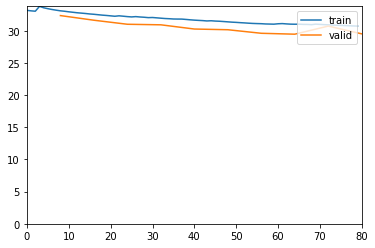

In [ ]:
learn.fit(10, 1e-2)

epoch,train_loss,valid_loss,time
0,30.635380,31.453007,00:07
1,30.708073,29.228495,00:07
2,30.276190,29.188540,00:07
3,30.190994,29.384850,00:07
4,30.084539,29.837725,00:07
5,30.104218,29.353439,00:07
6,30.231316,29.179119,00:08
7,30.294014,29.263584,00:07
8,30.142815,29.471642,00:08
9,30.404392,29.266319,00:07


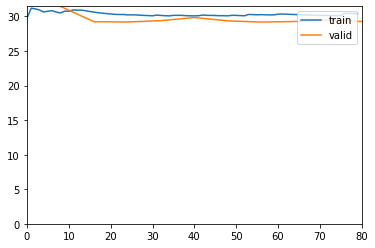

In [ ]:
learn.fit(10, 1e-2)

In [ ]:
learn.model.state_dict()

OrderedDict([('transition_matrices',
              tensor([[ 1.0386,  0.0701, -0.0280],
                      [-0.0137,  1.0555, -0.0409],
                      [ 0.0375,  0.0352,  1.0101]])),
             ('transition_offsets', tensor([-0.0004,  0.0227, -0.0098])),
             ('transition_cov_raw',
              tensor([[0.3820, 0.1724, 0.0218],
                      [0.2307, 0.6117, 0.0468],
                      [0.0504, 0.0040, 0.4256]])),
             ('obs_matrices',
              tensor([[ 0.3452, -0.0921, -0.0421],
                      [ 0.1080,  0.6222, -0.0347],
                      [ 0.0855, -0.0280,  0.4244]])),
             ('obs_offsets', tensor([ 0.0098, -0.0757, -0.0037])),
             ('obs_cov_raw',
              tensor([[1., 0., 0.],
                      [0., 1., 0.],
                      [0., 0., 1.]])),
             ('initial_state_mean', tensor([-0.2185,  0.1736, -0.0210])),
             ('initial_state_cov_raw',
              tensor([[ 1.2271, -0.2022,  0.

In [ ]:
from pyprojroot import here

In [ ]:
torch.sateve(learn.model, here('trained_models'))

In [ ]:
learn.model.obs_cov

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 1.0000]])

In [ ]:
learn.model.transition_cov_raw

Parameter containing:
tensor([[0.5060, 0.1494, 0.1067],
        [0.1800, 0.5987, 0.0379],
        [0.1164, 0.0090, 0.5540]], requires_grad=True)

In [ ]:
import meteo_imp

In [ ]:
meteo_imp.kalman.filter.posdef_log

""


In [ ]:
len(obs_cov_history.params)

90

In [ ]:
obs_cov_history.params[-1]

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 1.0000]])

In [ ]:
torch.tensor(list(map(symmetric_upto, obs_cov_history.params)))

tensor([-8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8,
        -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8,
        -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8,
        -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8,
        -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8, -8])

In [ ]:
torch.linalg.eigvalsh(obs_cov_history.params[-1])

tensor([1.0000, 1.0000, 1.0000])

In [ ]:
torch.linalg.cholesky_ex(obs_cov_history.params[-1])

torch.return_types.linalg_cholesky_ex(
L=tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]),
info=tensor(0, dtype=torch.int32))

In [ ]:
tt = torch.tensor([[ 1.0696,  0.5199, -0.5249],
        [ 0.5484,  1.1091,  0.5322],
        [-0.5279,  0.5506,  1.0742]])

In [ ]:
torch.linalg.eigvalsh(tt)

tensor([-3.3343e-04,  1.5997e+00,  1.6536e+00])

In [ ]:
symmetric_upto(tt)

-1

In [ ]:
texps = torch.tensor(exps).to(torch.float32)

In [ ]:
texps.mean()

tensor(-7.9764)

In [ ]:
texps.max()

tensor(-5.)

[<matplotlib.lines.Line2D>]

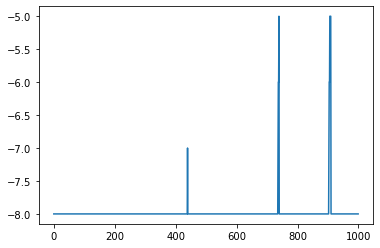

In [ ]:
plt.plot(texps[-1000:])

[<matplotlib.lines.Line2D>]

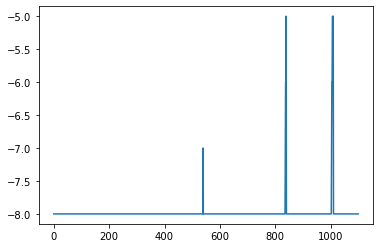

In [ ]:
plt.plot(texps)

In [ ]:
is_posdef2(torch.tensor([[1.7827, 1.6112, 1.1352],
        [1.6120, 1.4575, 1.0272],
        [1.1364, 1.0269, 0.7395]]))

(False, tensor([-9.4780e-05,  1.2683e-02,  3.9671e+00]))

In [ ]:
is_posdef2(learn.transition_cov)

(True, tensor([0.1232, 0.2985, 0.5808], grad_fn=<LinalgEighBackward0>))

In [ ]:
is_posdef2(learn.obs_cov)

(True, tensor([1.0000, 1.0000, 1.0000]))

In [ ]:
is_posdef2(learn.initial_state_cov)

(True, tensor([0.8877, 1.0164, 1.3814], grad_fn=<LinalgEighBackward0>))

this matrix makes no sense at all!!!

In [ ]:
learn.obs_cov

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 1.0000]])

In [ ]:
# torch.save(learn.model.state_dict(), "partial_traning_15_dec_not_pos_def_error")

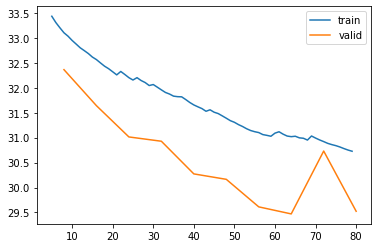

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# learn.lr_find()

In [ ]:
display_as_row(learn.model.get_info())

In [ ]:
learn.show_results()

TypeError: isinstance() arg 2 must be a type, a tuple of types, or a union